### UNBALANCED DATASET 
- https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set  
- http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/  
- https://github.com/scikit-learn-contrib/imbalanced-learn  
- https://shiring.github.io/machine_learning/2017/04/02/unbalanced  


#### TRY small equal subset of ALL DATA  
N=2000 each : a bit above chance model v0/v1 (acc~55-61%) || Not great ...  ref -- model_v1#.h5  
Ref: http://localhost:8888/notebooks/load_Imgs_runtestCNN_v0.ipynb


#### > TRY ALL DATA  -- 1:10 ratio train-test   
not great -- zero recall for images with buildings... ref -- model_v2#.h5   
Ref: http://localhost:8888/notebooks/load_Imgs_runtestCNN_v1.ipynb


#### >> TRY Upsampling Bclass and Downsampling NBclass
N=6000 each : PROMISING with cnn_model v3 (train-test acc~97%) | transfer_VGG16_model v4 (train-test acc~93%)   
Ref: http://localhost:8888/notebooks/load_Imgs_runtestCNN_v1.ipynb     ||  http://localhost:8888/notebooks/load_Imgs_runtestCNN_v2_tryVGG16Transfer.ipynb
- train-test: N=6000 each --- b_2000 + 4000_randomSampling || nb_6000   
- ** however val data also has mixture of oversampled data... so not ideal...


#### >>> TRY Using same (1:10)% but add Image Augmented Bclass to create similar # of samples in both classes  
http://localhost:8888/notebooks/Use_ImageDataGenerator_makeSynthetic_v2.ipynb  
train-test: N=10000 each --- b_1000 + aug_b_9000  || nb_10000   
holdout: b_400 || nb_4000   
Ref: http://localhost:8888/notebooks/load_Imgs_runtestCNN_v1-AugmentedXY.ipynb   || http://localhost:8888/notebooks/load_Imgs_runtestCNN_v1-AugmentedXY_run2.ipynb
 

##  

#### General REQs

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

In [7]:
# !pwd
# path='/Users/hrm/Documents/Dropbox/DSrelated/DG_datachallenge'
path = '/home/ubuntu/pynb/DG_datachallenge'

#### File paths

In [8]:
## Get fullpaths to img files
import glob, os, sys

btmp = glob.glob(os.path.join(path+'/building_set/buildings/','*.tif')) #os.listdir( path+'/building_set/buildings/' )
# buildingFileNames

abtmp = glob.glob(os.path.join(path+'/building_set/augmented/','*.tif')) #os.listdir( path+'/building_set/buildings/' )
# augbuildingFileNames

nbtmp = glob.glob(os.path.join(path+'/building_set/no_buildings/','*.tif')) #os.listdir( path+'/building_set/no_buildings' )
# nobuildingFileNames

# buildingFileNames = btmp
# nobuildingFileNames = nbtmp

In [9]:
abtmp[:3]

['/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_415082__0_1497.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_556542__0_5553.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_752793__0_2246.tif']

In [10]:
len(btmp), len(abtmp) , len(nbtmp)

(2000, 19989, 20000)

In [14]:
# .2*2000, 2000 -.2*2000, 20000 -.2*2000
# (400.0, 1600.0, 19600.0)

factor = 0.2
factor*2000, 2000 -factor*2000, 20000 -factor*2000

(400.0, 1600.0, 19600.0)

#### Define holdout | traintest data IDX

In [15]:
def getTrainTestHoldOutSplitIDX(holdoutSize, classSZ):
    
    holdID = np.random.choice(classSZ,holdoutSize,replace=False).tolist()
    testID = list(set.difference(set(list(range(0,classSZ))),set(holdID)))
        
    return holdID, testID

In [16]:
BclassSZ = len(btmp)
aBclassSZ = len(abtmp)
NBclassSZ = len(nbtmp)

bHoldID, bTrainTestID = getTrainTestHoldOutSplitIDX(int(0.2*BclassSZ), BclassSZ)
nbHoldID, nbTrainTestID = getTrainTestHoldOutSplitIDX(int(0.2*NBclassSZ), NBclassSZ)

print('bHoldID: {0}   | bTrainTestID: {1}'.format(len(bHoldID), len(bTrainTestID)) )
print('nbHoldID: {0} | nbTrainTestID: {1}'.format(len(nbHoldID), len(nbTrainTestID)))
print()

aBclassSZuse = len(nbTrainTestID) - len(bTrainTestID)
print('aBclassSZuse: {0}'.format(aBclassSZuse))

abTrainTestID = np.random.choice(aBclassSZ,aBclassSZuse,replace=True).tolist()
print('abTrainTestID: {0}'.format(len(abTrainTestID)))
print()
print('bTrainTestID + abTrainTestID: {0}'.format(len(abTrainTestID) + len(bTrainTestID)))


bHoldID: 400   | bTrainTestID: 1600
nbHoldID: 4000 | nbTrainTestID: 16000

aBclassSZuse: 14400
abTrainTestID: 14400

bTrainTestID + abTrainTestID: 16000


#### Define Holdout 

In [17]:
bHoldF0 = [btmp[i] for i in bHoldID]
nbHoldF0 = [nbtmp[i] for i in nbHoldID]

In [176]:
bHoldDF = pd.DataFrame(bHoldF0, columns=['filename'])
bHoldDF['Blabel'] = 1
bHoldDF['augment'] = 0

nbHoldDF = pd.DataFrame(nbHoldF0, columns=['filename'])
nbHoldDF['Blabel'] = 0
nbHoldDF['augment'] = 0

holdFileIdx_all = pd.concat([bHoldDF,nbHoldDF]).reset_index()
holdFileIdx_all.rename(columns={'index':'Oidx'}, inplace=True)


In [177]:
holdFileIdx_all.shape #(4400, 3) || index reset (4400, 4)

(4400, 4)

In [ ]:
# holdFileIdx_all.to_csv(path+'/building_set/XY_holdout_all.csv')
# FileImgPaths.to_csv(path+'/building_set/XY_holdout_all.csv')


#### Get filepaths of keras ImageDataGenerator randomly-augmented files that DO NOT correspond to holdOUT building image files

In [20]:
# import pandas as pd
# hold = pd.read_csv('./building_set/XY_holdout_all.csv',index_col=0)
hold =holdFileIdx_all

# [i.split('/')[-1][:-4] for i in hold.filename]
hold['fileNo']=hold.filename.apply(lambda x: x.split('/')[-1][:-4])

bFno = hold[hold.Blabel==1].fileNo
print(bFno.shape)

# abtmp[100].split('/')[-1].split('__')
# ['b_585046', '0_8370.tif']
# abtmp[100].split('/')[-1].split('__')[0][2:]

getFilePrefixes = [ab.split('/')[-1].split('__')[0][2:] for ab in abtmp]

nonHold_getFileNo = [f for f in getFilePrefixes if int(f) not in list(bFno.astype(int))]

print(np.unique(nonHold_getFileNo).shape)

nonHold_Filepath = [ab for ab in abtmp  
                    if int(ab.split('/')[-1].split('__')[0][2:]) in list(pd.Series(nonHold_getFileNo, dtype='int'))]

print(len(nonHold_Filepath))

(400,)
(1600,)
15993


In [21]:
nonHold_Filepath[:10]

['/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_415082__0_1497.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_556542__0_5553.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_752793__0_2246.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_508666__0_6998.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_604608__0_9398.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_329833__0_9384.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_516196__0_782.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_293752__0_7101.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_541217__0_1767.tif',
 '/home/ubuntu/pynb/DG_datachallenge/building_set/augmented/b_323937__0_4423.tif']

#### Derive filelists for traintest data

In [ ]:
## IF using ALL remaining files... NOT USING wrt MEMORY overload....

bTrainTestF0 = [btmp[i] for i in bTrainTestID]
abTrainTestF0 = [abtmp[i] for i in abTrainTestID]
nbTrainTestF0 = [nbtmp[i] for i in nbTrainTestID]

In [ ]:
## NOT using all remaining files -- memory issues

In [22]:
Nimg = 10000

btmp1 = [btmp[i] for i in np.random.choice(len(btmp),int(0.1*Nimg),replace=False).tolist()]

abtmp1 = [nonHold_Filepath[i] for i in np.random.choice(len(nonHold_Filepath),
                                                        #Nimg-len(bTrainTestF0)-len(bHoldID),replace=True).tolist()]
                                                        Nimg-int(0.1*Nimg),replace=False).tolist()]

nbtmp1 = [nbtmp[i] for i in np.random.choice(len(nbtmp),Nimg,replace=False).tolist()]



In [23]:
len(btmp1), len(abtmp1), len(nbtmp1)

(1000, 9000, 10000)

#### rename... traintest tmp filepaths

In [25]:
bTrainTestF1 = btmp1
abTrainTestF1 = abtmp1
nbTrainTestF1 = nbtmp1

In [ ]:
# TMP = bTrainTestF0[:]
# len(TMP) #1600

In [ ]:
# TMP.extend(abTrainTestID)

In [ ]:
# len(TMP),len(abTrainTestID)
# # (16000, 14400)

#### Concat traintest filenames

In [15]:
## IF Using ALL remaining files
# bTrainTestDF = pd.DataFrame(bTrainTestF0, columns=['filename'])
# bTrainTestDF['Blabel'] = 1
# bTrainTestDF['augment'] = 0

# abTrainTestDF = pd.DataFrame(abTrainTestF0, columns=['filename'])
# abTrainTestDF['Blabel'] = 1
# abTrainTestDF['augment'] = 1

# nbTrainTestDF = pd.DataFrame(nbTrainTestF0, columns=['filename'])
# nbTrainTestDF['Blabel'] = 0
# nbTrainTestDF['augment'] = 0

# traintestFileIdx_all = pd.concat([bTrainTestDF,abTrainTestDF,nbTrainTestDF])
# traintestFileIdx_all = pd.concat([bTrainTestDF,abTrainTestDF,nbTrainTestDF]).reset_index()
# traintestFileIdx_all.rename(columns={'index':'Oidx'}, inplace=True)

#.shape #(32000, 3) --> TOO LARGE to hold in memory...

In [178]:
## USING Nimg -------------------------------------------------------
bTrainTestDF = pd.DataFrame(bTrainTestF1, columns=['filename'])
bTrainTestDF['Blabel'] = 1
bTrainTestDF['augment'] = 0

abTrainTestDF = pd.DataFrame(abTrainTestF1, columns=['filename'])
abTrainTestDF['Blabel'] = 1
abTrainTestDF['augment'] = 1

nbTrainTestDF = pd.DataFrame(nbTrainTestF1, columns=['filename'])
nbTrainTestDF['Blabel'] = 0
nbTrainTestDF['augment'] = 0

traintestFileIdx_all = pd.concat([bTrainTestDF,abTrainTestDF,nbTrainTestDF]).reset_index()
traintestFileIdx_all.rename(columns={'index':'Oidx'}, inplace=True)

In [179]:
traintestFileIdx_all.shape #.iloc[list(range(1601,1800))]#.shape #(32000, 3) --> TOO LARGE to hold in memory...

(20000, 4)

In [28]:
traintestFileIdx_all.Blabel.value_counts()

1    10000
0    10000
Name: Blabel, dtype: int64

In [29]:
holdFileIdx_all.Blabel.value_counts()

0    4000
1     400
Name: Blabel, dtype: int64

#### Define basic image preprocessing 

In [30]:
import numpy as np
from skimage import color, exposure, transform

# NUM_CLASSES = 2
IMG_SIZE = 256

def preprocess_img(img):
    img=np.array(img)
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE), mode='constant')

    # roll color axis to axis 0
    #img = np.rollaxis(img,-1)

    return img

#### Define function to load & run image processing --> image np_arrays

In [31]:
from skimage import io
import os
import glob

def get_Fileclass(img_path):
    return str(img_path.split('/')[-2])

def get_FileName(img_path):
    return str(img_path.split('/')[-1])



def makeImageXYvars(FileIdx_file):

    imgs = []
    labels = []
    
    cnt = 0
    N = 0 
    imgN = 500
    
    
    FileImgPaths = FileIdx_file

    # for img_path in TrainImgPaths.filename:
    for img_path in FileImgPaths.filename:    

        img = preprocess_img(io.imread(img_path))  ## add image more pre-processing later...

        label = get_Fileclass(img_path)
        #print('preprocessing image : '+ label + ' -- ' + get_FileName(img_path))

        imgs.append(img)
        #labels.append(label)

        if cnt%imgN==0:
            if N==0 & cnt==0:
                print('start processing....')
            else:
                print('preprocessed {0} images ...'.format((N*imgN)))
            N += 1
        
    cnt += 1
        
    if cnt>=len(FileIdx_file):
        ## Done... print:            
        print('preprocessed {0} images ...'.format(cnt))
    
    
    X = np.array(imgs, dtype='float32')

    # Make one hot targets
    Y= FileImgPaths.Blabel.values 

    return X, Y, FileImgPaths



#### Run image processing --> np_arrays

In [71]:
# X,Y, FileImgPaths = makeImageXYvars(FileIdx_Train)
# X,Y, FileImgPaths = makeImageXYvars(FileIdx_Test)


# X,Y, FileImgPaths = makeImageXYvars(holdFileIdx_all)
X,Y, FileImgPaths = makeImageXYvars(traintestFileIdx_all)

start processing....
preprocessed 500 images ...
preprocessed 1000 images ...
preprocessed 1500 images ...
preprocessed 2000 images ...
preprocessed 2500 images ...
preprocessed 3000 images ...
preprocessed 3500 images ...
preprocessed 4000 images ...
preprocessed 4500 images ...
preprocessed 5000 images ...
preprocessed 5500 images ...
preprocessed 6000 images ...
preprocessed 6500 images ...
preprocessed 7000 images ...
preprocessed 7500 images ...
preprocessed 8000 images ...
preprocessed 8500 images ...
preprocessed 9000 images ...
preprocessed 9500 images ...
preprocessed 10000 images ...
preprocessed 10500 images ...
preprocessed 11000 images ...
preprocessed 11500 images ...
preprocessed 12000 images ...
preprocessed 12500 images ...
preprocessed 13000 images ...
preprocessed 13500 images ...
preprocessed 14000 images ...
preprocessed 14500 images ...
preprocessed 15000 images ...
preprocessed 15500 images ...
preprocessed 16000 images ...
preprocessed 16500 images ...
preproces

In [72]:
Y.shape, Y
#holdout ((4400,), array([1, 1, 1, ..., 0, 0, 0]))
#testtrain ((20000,), array([1, 1, 1, ..., 0, 0, 0]))

((20000,), array([1, 1, 1, ..., 0, 0, 0]))

In [73]:
### RESHAPE Y --- maybe do this when running the convnet -- combine y+imagefilename so they correspond ???
from keras.utils import np_utils
Y=np_utils.to_categorical(Y, 2)

In [189]:
X.shape
#holdout (4400, 256, 256, 3)
# testtrain (20000, 256, 256, 3)

(20000, 256, 256, 3)

In [190]:
Y.shape

(20000, 2)

In [ ]:
import keras
keras.backend.image_data_format()
# 'channels_last'

#### SAVE FILES

In [191]:
### SAVE FILES

import pickle
import numpy as np

# np.save(path+'/building_set/TrainX_v0',X)
# np.save(path+'/building_set/TrainY_v0',Y)


# np.save(path+'/building_set/TestX_v0',X)
# np.save(path+'/building_set/TestY_v0',Y)


## LARGE files....
# np.save(path+'/building_set/X_all',X)
# np.save(path+'/building_set/Y_all',Y)

# np.save(path+'/building_set/X_ubdnb6000_all',X)
# np.save(path+'/building_set/Y_ubdnb6000_all',Y)
# FileImgPaths.to_csv(path+'/building_set/XY_ubdnb6000_all.csv')



np.save(path+'/building_set/X_holdout_all',X)
np.save(path+'/building_set/Y_holdout_all',Y)
# FileImgPaths.to_csv(path+'/building_set/XY_holdout_all.csv')
holdFileIdx_all.to_csv(path+'/building_set/XY_holdout_all.csv')

np.save(path+'/building_set/X_traintest_all',X)
np.save(path+'/building_set/Y_traintest_all',Y)
# FileImgPaths.to_csv(path+'/building_set/XY_traintest_all.csv')
traintestFileIdx_all.to_csv(path+'/building_set/XY_traintest_all.csv')



#### LOAD FILES

In [ ]:
# LOAD saved vars


# f = np.load('filepath.npy')
# f.shape


In [187]:
# tt =pd.read_csv(path+'/building_set/XY_holdout_all.csv', index_col=0)
tt =pd.read_csv(path+'/building_set/XY_testtrain_all.csv', index_col=0)

In [188]:
tt.shape

(20000, 4)

In [192]:
# t = holdFileIdx_all.reset_index()
# t.rename(columns={'index':'Oidx'}, inplace=True)
# t.index.duplicated().sum()
# t

### CHECK train-test-split | images

In [197]:
### Include all images
from sklearn.model_selection import train_test_split

train,test = train_test_split(holdFileIdx_all, test_size=0.2, stratify=holdFileIdx_all.Blabel)
train1,test1 = train_test_split(traintestFileIdx_all, test_size=0.2, stratify=traintestFileIdx_all.Blabel)

# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, 
#                                                 test_size=0.2, random_state=4859, 
#                                                 stratify=Y)

In [198]:
len(train), len(test) , len(train1), len(test1)
#holdout (3520, 880)
# testtrain (16000, 4000)

(3520, 880, 16000, 4000)

In [199]:
holdFileIdx_all.index.duplicated().sum() , traintestFileIdx_all.index.duplicated().sum()

(0, 0)

In [200]:
traintestFileIdx_all.Blabel.value_counts()

1    10000
0    10000
Name: Blabel, dtype: int64

In [204]:
train1.index.duplicated().sum(), test1.index.duplicated().sum()

(0, 0)

In [205]:
traintestFileIdx_all.iloc[train1.index.tolist()].Blabel.value_counts()

1    8000
0    8000
Name: Blabel, dtype: int64

In [208]:
traintestFileIdx_all.iloc[test1.index.tolist()].Blabel.value_counts()

1    2000
0    2000
Name: Blabel, dtype: int64

In [209]:
train.index.duplicated().sum(), test.index.duplicated().sum()

(0, 0)

In [206]:
holdFileIdx_all.iloc[test.index.tolist()].Blabel.value_counts()

0    800
1     80
Name: Blabel, dtype: int64

In [207]:
holdFileIdx_all.iloc[train.index.tolist()].Blabel.value_counts()

0    3200
1     320
Name: Blabel, dtype: int64

In [211]:
traintestFileIdx_all.iloc[train1.index.tolist()]

,Oidx,filename,Blabel,augment
4323,3323,/home/ubuntu/pynb/DG_datachallenge/building_se...,1,1
13924,3924,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0
3849,2849,/home/ubuntu/pynb/DG_datachallenge/building_se...,1,1
7681,6681,/home/ubuntu/pynb/DG_datachallenge/building_se...,1,1
19782,9782,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0
2014,1014,/home/ubuntu/pynb/DG_datachallenge/building_se...,1,1
19119,9119,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0
9619,8619,/home/ubuntu/pynb/DG_datachallenge/building_se...,1,1
7303,6303,/home/ubuntu/pynb/DG_datachallenge/building_se...,1,1
19611,9611,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0


In [42]:
holdFileIdx_all.iloc[train.index.tolist()]#Blabel.value_counts() #>>#reset index

,filename,Blabel,augment,fileNo
460,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0,442276
2883,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0,479071
2654,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0,380935
558,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0,295305
183,/home/ubuntu/pynb/DG_datachallenge/building_se...,1,0,286400
696,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0,515429
99,/home/ubuntu/pynb/DG_datachallenge/building_se...,1,0,195212
2048,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0,785996
587,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0,724567
2839,/home/ubuntu/pynb/DG_datachallenge/building_se...,0,0,356181


### CHECK images

In [43]:
from keras.preprocessing.image import load_img #, img_to_array

In [ ]:
## TrainTest

0  || [nB : B] == [ 1.  0.]


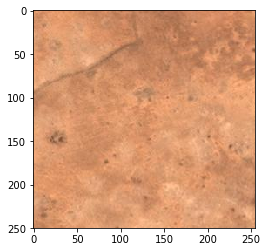

In [215]:
n=1
img=load_img(traintestFileIdx_all.iloc[train1.index.tolist()[n]].filename)
print(traintestFileIdx_all.iloc[train1.index.tolist()[n]].Blabel ,
      ' || [nB : B] == {}'.format(Y[train1.index.tolist()[n]]) )
plt.imshow(img)

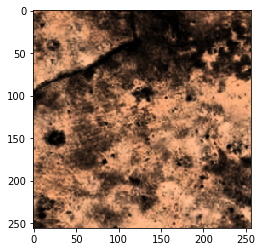

In [216]:
plt.imshow(X[train1.index.tolist()[n],:,:,:])

1  || [nB : B] == [ 0.  1.]


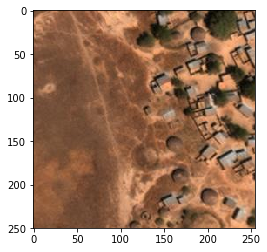

In [217]:
n=5
img=load_img(traintestFileIdx_all.iloc[train1.index.tolist()[n]].filename)
print(traintestFileIdx_all.iloc[train1.index.tolist()[n]].Blabel ,
      ' || [nB : B] == {}'.format(Y[train1.index.tolist()[n]]) )
plt.imshow(img)

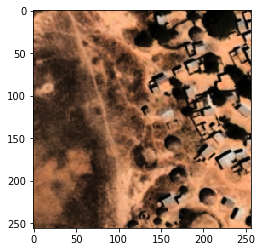

In [218]:
plt.imshow(X[train1.index.tolist()[n],:,:,:])

In [ ]:
## Holdout

0  || [nB : B] == [ 1.  0.]


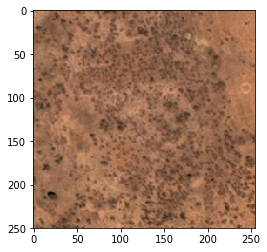

In [64]:
n=3
img=load_img(holdFileIdx_all.iloc[train.index.tolist()[n]].filename)
print(holdFileIdx_all.iloc[train.index.tolist()[n]].Blabel , ' || [nB : B] == {}'.format(Y[train.index.tolist()[n]]) )
plt.imshow(img)

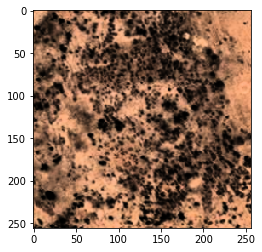

In [65]:
plt.imshow(X[train.index.tolist()[n],:,:,:])

1  || [nB : B] == [ 0.  1.]


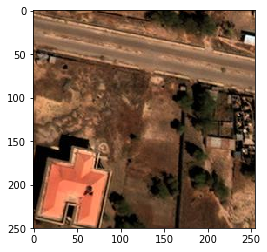

In [56]:
n=4
img=load_img(holdFileIdx_all.iloc[train.index.tolist()[n]].filename)
print(holdFileIdx_all.iloc[train.index.tolist()[n]].Blabel , ' || [nB : B] == {}'.format(Y[train.index.tolist()[n]]) )
plt.imshow(img)

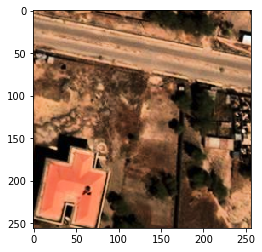

In [57]:
plt.imshow(X[train.index.tolist()[n],:,:,:])

0  || [nB : B] == [ 1.  0.]


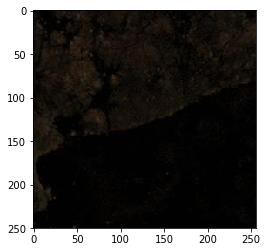

In [62]:
n=2
img=load_img(holdFileIdx_all.iloc[train.index.tolist()[n]].filename)
print(holdFileIdx_all.iloc[train.index.tolist()[n]].Blabel , ' || [nB : B] == {}'.format(Y[train.index.tolist()[n]]) )
plt.imshow(img)

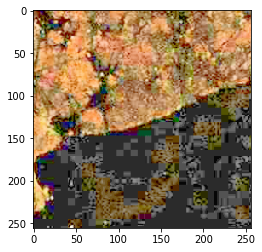

In [63]:
plt.imshow(X[train.index.tolist()[n],:,:,:])